#Data Processing - US Census Bureau

# Introduction

For this project we will be writing functions to process data from the US Census Bureau and utilizing a portion of that data to fit, train, and test a **Simple Linear Regression Model** and a **Multiple Linear Regression Model**. We will then calculate and compare the **Mean Squared Error** of those models and discuss the results.

# Data Processing in steps

First step is to import all necessary packages to read in, process, and prepare our data.


In [ ]:
#importing packages/modules
import pandas as pd
import numpy as np
from functools import reduce
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

##Step 1: Reading in our Data

The below code reads in the EDU01a dataset and renames Area_name to standardize casing across all of our variables.

Utilizing `.info()` method to understand how our variables are stored.

In [ ]:
#reading in EDU01a
census = pd.read_csv("https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv")

In [ ]:
census = census.rename(columns={"Area_name":"area_name"})
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   area_name    3198 non-null   object
 1   STCOU        3198 non-null   int64 
 2   EDU010187F   3198 non-null   int64 
 3   EDU010187D   3198 non-null   int64 
 4   EDU010187N1  3198 non-null   int64 
 5   EDU010187N2  3198 non-null   int64 
 6   EDU010188F   3198 non-null   int64 
 7   EDU010188D   3198 non-null   int64 
 8   EDU010188N1  3198 non-null   int64 
 9   EDU010188N2  3198 non-null   int64 
 10  EDU010189F   3198 non-null   int64 
 11  EDU010189D   3198 non-null   int64 
 12  EDU010189N1  3198 non-null   int64 
 13  EDU010189N2  3198 non-null   int64 
 14  EDU010190F   3198 non-null   int64 
 15  EDU010190D   3198 non-null   int64 
 16  EDU010190N1  3198 non-null   int64 
 17  EDU010190N2  3198 non-null   int64 
 18  EDU010191F   3198 non-null   int64 
 19  EDU010191D   3198 non-null 

In [ ]:
#Subsetting to look at enrollment data by area_name
census = census.loc[:, census.columns.str.endswith(('area_name','STCOU', 'D'))]
census.head()

,area_name,STCOU,EDU010187D,EDU010188D,EDU010189D,EDU010190D,EDU010191D,EDU010192D,EDU010193D,EDU010194D,EDU010195D,EDU010196D
0,UNITED STATES,0,40024299,39967624,40317775,40737600,41385442,42088151,42724710,43369917,43993459,44715737
1,ALABAMA,1000,733735,728234,730048,728252,725541,726150,728014,730509,727989,736825
2,"Autauga, AL",1001,6829,6900,6920,6847,7008,7137,7152,7381,7568,7834
3,"Baldwin, AL",1003,16417,16465,16799,17054,17479,17983,18735,19384,19961,20699
4,"Barbour, AL",1005,5071,5098,5068,5156,5173,5252,5135,5111,5017,5053


##Step 2: Reshaping our Data


Below we are using the `.melt()` to reshape our data from wide to long.

Then we are inspecting using `.head()` to confirm our output is what we desired.

In [ ]:
#reshaping data set and checking results
census = census.melt(id_vars=['area_name', 'STCOU'], var_name='edu_code', value_name='enrollment')
census.head()

,area_name,STCOU,edu_code,enrollment
0,UNITED STATES,0,EDU010187D,40024299
1,ALABAMA,1000,EDU010187D,733735
2,"Autauga, AL",1001,EDU010187D,6829
3,"Baldwin, AL",1003,EDU010187D,16417
4,"Barbour, AL",1005,EDU010187D,5071


## Step 3: Cleaning & Preparing Data

We need to derive a year and measurment variable from the `edu_code` variable to prepare for modeling. To start the loop we iniatialized the two new variables and ran a for loop that iterates through each row. `edu_code` has a nomenclature where we can glean the year and measurment variables. Later, this variable will be dropped once we derive the desired variables using the `.drop` method.

 We have to be careful as some years are from the 1900's and others are from the 2000's. Adding in a `if/else` statement will help us control the flow of data. Since we know that the data is up to 2010, we used this to control which two digits correspond to which century. Also, something to note, we had to convert year as an interger type object in the process and measurement was kept as a string type object. Finally we use the `.head()` method to confirm our for loop executed appropriately.

In [ ]:
#Looping through rows to derive year and measurement variable
census['Year'] = 0
census['Measurement'] = ''

for index, row in census.iterrows():
    year1str = row['edu_code'][7:9]
    Measurement = row['edu_code'][0:7]

    year1d = int(year1str)

    if year1d > 20:
        year = (1900 + year1d)
    else:
        year = 2000 + year1d
    census.at[index, 'Year'] = year
    census.at[index, 'Measurement'] = Measurement

census['Year'] = census['Year'].astype(int)
census = census.drop('edu_code', axis = 1)

census.head()

,area_name,STCOU,enrollment,Year,Measurement
0,UNITED STATES,0,40024299,1987,EDU0101
1,ALABAMA,1000,733735,1987,EDU0101
2,"Autauga, AL",1001,6829,1987,EDU0101
3,"Baldwin, AL",1003,16417,1987,EDU0101
4,"Barbour, AL",1005,5071,1987,EDU0101


##Step 4: Splitting Data by county and non-county level

Here we are splitting the data into two data frames. We are using a lambda function with a `.apply` method to seperate out the values that contain a comma. `area_name` values with a comma are county level values. Those without a comma are placed into the non_county_lvl data frame. We used `np.logical_not` to help us split the data. In this block of code we also removed the District of Columbia from the `non_county_lvl` data frame to ensure it is represented only once and within our state level data. `non_county_lvl` also had an all caps verison, DISTRICT OF COLUMBIA,  which is why we removed the lower case verison.

In [ ]:
#spliting into two data frames: county & non-county level
census['area_type'] = census['area_name'].apply(lambda x:
                                                True if ',' in x else False)
census['area_type1'] = np.logical_not(census['area_type'])

#subsetting
county_lvl     = census[census['area_type'] == True] \
                    .drop(['area_type1', 'area_type'], axis=1)
non_county_lvl = census[census['area_type1'] == True] \
                    .drop(['area_type1', 'area_type'], axis=1)

#removing washington DC from non_county df
non_county_lvl = non_county_lvl[non_county_lvl['area_name'] != 'District of Columbia']

non_county_lvl.head(3)

,area_name,STCOU,enrollment,Year,Measurement
0,UNITED STATES,0,40024299,1987,EDU0101
1,ALABAMA,1000,733735,1987,EDU0101
69,ALASKA,2000,102872,1987,EDU0101


In [ ]:
#taking a look
county_lvl.head(3)

,area_name,STCOU,enrollment,Year,Measurement
2,"Autauga, AL",1001,6829,1987,EDU0101
3,"Baldwin, AL",1003,16417,1987,EDU0101
4,"Barbour, AL",1005,5071,1987,EDU0101


##Step 5: Deriving State for county_lvl

In this step we are adding the variable `state` to each observation.

We utilized `.astype()` method to complete this as well as slicing out the last two letters from `area_name` to accomplish this.

In [ ]:
#Creating variable for county state
county_lvl['State'] = county_lvl['area_name'].astype(str).str[-2:]
county_lvl.head(3)

,area_name,STCOU,enrollment,Year,Measurement,State
2,"Autauga, AL",1001,6829,1987,EDU0101,AL
3,"Baldwin, AL",1003,16417,1987,EDU0101,AL
4,"Barbour, AL",1005,5071,1987,EDU0101,AL


##Step 6: Creating a division variable using a dictionary

In this step we are creating a division variable based on `area_name` groupings. Using the state groupings from this [link](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States) for divisons, we created a dictionary to group the states and a function to return the appropriate division based on state name.

In [ ]:
#state/division var creation
#the below should be based on division not Region
divi_state = {
    'new england': ['CONNECTICUT', 'MAINE', 'MASSACHUSETTS', 'NEW HAMPSHIRE', 'RHODE ISLAND', 'VERMONT' ],
    'mid_atlantic': ['NEW JERSEY', 'NEW YORK', 'PENNSYLVANIA'],
    'east north central': ['ILLINOIS', 'INDIANA', 'MICHIGAN', 'OHIO', 'WISCONSIN'],
    'west north central': ['IOWA', 'KANSAS', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'SOUTH DAKOTA'],
    'south atlantic': ['DELAWARE', 'FLORIDA', 'GEORGIA', 'MARYLAND', 'NORTH CAROLINA', 'SOUTH CAROLINA', 'VIRGINIA', 'WEST VIRGINIA', 'DISTRICT OF COLUMBIA'],
    'east south central': ['ALABAMA', 'KENTUCKY', 'MISSISSIPPI', 'TENNESSEE'],
    'west south central': ['ARKANSAS', 'LOUISIANA', 'OKLAHOMA', 'TEXAS'],
    'mountain': ['ARIZONA', 'COLORADO', 'IDAHO', 'MONTANA', 'NEVADA', 'NEW MEXICO', 'UTAH', 'WYOMING'],
    'pacific': ['ALASKA', 'CALIFORNIA', 'HAWAII', 'OREGON', 'WASHINGTON']
}

In [ ]:
def creat_div(x):
  if x in divi_state['new england']:
    return('New England')
  elif x in divi_state['mid_atlantic']:
    return('Mid Atlantic')
  elif x in divi_state['east north central']:
    return('East North Central')
  elif x in divi_state['west north central']:
    return('West North Central')
  elif x in divi_state['south atlantic']:
    return('South Atlantic')
  elif x in divi_state['east south central']:
    return('East South Central')
  elif x in divi_state['west south central']:
    return('West South Central')
  elif x in divi_state['mountain']:
    return('Mountain')
  elif x in divi_state['pacific']:
    return('Pacific')
  else:
    return('ERROR')



Lastly, we vectorize our ```creat_div()``` function to create a numpy array of division names corresponding to the state names in ```non_county_lvl``` data. We then create our ```non_county_lvl.division``` variable using this array.

In [ ]:
div_vect = np.vectorize(creat_div, otypes=[str])
division = div_vect(non_county_lvl['area_name'])
non_county_lvl['division'] = division
non_county_lvl.head()


,area_name,STCOU,enrollment,Year,Measurement,division
0,UNITED STATES,0,40024299,1987,EDU0101,ERROR
1,ALABAMA,1000,733735,1987,EDU0101,East South Central
69,ALASKA,2000,102872,1987,EDU0101,Pacific
99,ARIZONA,4000,609411,1987,EDU0101,Mountain
115,ARKANSAS,5000,429260,1987,EDU0101,West South Central


# Function Writing

Here we are creating custom functions for what we have already done.

This allows us to repeat our processes on new and incoming data.

### Import Function: `import_data`
```import_data()``` function will read in the csv data, select appropriate columns, and melt the data frame into long format.


In [ ]:
def import_data(data, colname='enrollment'):
  data = pd.read_csv(data)
  data = data.rename(columns={"Area_name":"area_name"})
  data = data.loc[:, data.columns.str.endswith(('area_name','STCOU', 'D'))]
  data = data.melt(id_vars=['area_name', 'STCOU'], var_name='edu_code', value_name=colname)
  return data


### Data Processing Function: `measure_split`
```measure_split()``` function will add the variables ```year``` and ```measurement``` to our data frame based on the content of the ```edu_code``` variable.


In [ ]:
def measure_split(data):
  data['year'] = 0
  data['measurement'] = ''

  for index, row in data.iterrows():
    yr = row['edu_code'][7:9]
    measure = row['edu_code'][0:7]

    yr = int(yr)

    if yr > 20:
      year = (1900+yr)
    else:
      year = 2000+yr
    data.at[index, 'year'] = year
    data.at[index, 'measurement'] = measure

  data = data.drop('edu_code', axis = 1)
  return data

###Spliting County/Non-County Function: `data_split`
```data_split()``` function will determine if the row of the data frame is county level or state level and split the data frame accordingly. It also modifies each resulting data frame with additional variables depending on whether the data was split into county_level or state_level. Those imbedded functions are described below.

In [ ]:
def data_split(data):

  data['area_type'] = data['area_name'].apply(lambda x: True if ',' in x else False)
  data['area_type1'] = np.logical_not(data['area_type'])

  county = data[data['area_type'] == True].drop(['area_type1', 'area_type'], axis=1)
  state = data[data['area_type1'] == True].drop(['area_type1', 'area_type'], axis=1)

  # included 'DISTRICT OF COLUMBIA' in state_level data; 'District of Columbia' data is redundant, so it was removed

  state = state[state['area_name'] != 'District of Columbia']
  county = create_state(county)
  state = creatdiv(state)

  return(county, state)

###State Deriving Function: `create_state`
```create_state()``` adds a ```state``` variable based on the last two indices of the ```area_name``` string.

In [ ]:
def create_state(data):
  data['state'] = data['area_name'].astype(str).str[-2:]
  return data

### Division Variable Function: `creatdiv`
```creatdiv()``` creates the division variable for state level data utilizing numpy's ```vectorize()``` function.

In [ ]:
def creatdiv(data):
  div_vect = np.vectorize(creat_div, otypes=[str])
  division = div_vect(data['area_name'])
  data['division'] = division
  return data

###Wrapper Function: `create_dfs`
The wrapper function utilizes the `import_data`, `measure_split`, and `data_split` functions to read in and format new datasets. It will return a ```tuple``` with county_level data in the first indices ```[0]``` and state_level data in the second indices ```[1]```. This output is the output format of the last called function, ```data_split()```.

In [ ]:
def create_dfs(url, colname='enrollment'):
  a = import_data(url, colname=colname)
  b = measure_split(a)
  c = data_split(b)
  return c

# Call & Combine

Now that we can call in and split data, we'll want to figure out a way to combine multiple data calls into one object.

Let's start by calling ```create_dfs()``` on two separate pieces of data.

In [ ]:
#reading in EDU01a and EDU01b
edua = create_dfs("https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv", colname = 'enrollment')
edub = create_dfs("https://www4.stat.ncsu.edu/~online/datasets/EDU01b.csv", colname = 'enrollment')

Now we have two data objects, ```edua``` and ```edub```, each consisting of two data frames, ```county``` and ```state```. So we'll need to write another function that will take in these tuples and split and concatenate them appropriately so that the ```county``` data from each object is concatenated together and the ```state``` data from each object is concatenated together.

In our above example, we're trying to combine two data objects, ```edua``` and ```edub```, but ultimately we will want our function to be able to take in an unknown number of data objects so it can be used on current and future datasets consisting of an unknown number of objects. So we will utilize **unlimited positional arguments** notation for the function's argument.

To separate the ```county``` and ```state``` data, we will ```map()``` a **lambda**, or *inline*, function to the ```*args``` argument. This will create an array of ```county``` data frames and an array of ```state``` data frames.

We will then concatenate each of these data frame arrays using ```reduce()``` and another **lambda** function utilizing ```pd.concat()```.

Lastly, the function will return another tuple object consisting of the concatenated ```county``` data frame and the concatenated ```state``` data frame.

In [ ]:
def combine_data(*args):
  co = map(lambda r: r[0], *args)
  county = reduce(lambda x,y: pd.concat([x,y]), co)
  st = map(lambda r: r[1], *args)
  state = reduce(lambda x,y: pd.concat([x,y]), st)
  return (county, state)

Let's call our function on the two ```edu``` objects!

In [ ]:
#Combining edua and edud using our combine_data function
edu = combine_data([edua, edub])
edu

(            area_name  STCOU  enrollment  year measurement state
 2         Autauga, AL   1001        6829  1987     EDU0101    AL
 3         Baldwin, AL   1003       16417  1987     EDU0101    AL
 4         Barbour, AL   1005        5071  1987     EDU0101    AL
 5            Bibb, AL   1007        3557  1987     EDU0101    AL
 6          Blount, AL   1009        7319  1987     EDU0101    AL
 ...               ...    ...         ...   ...         ...   ...
 31975  Sweetwater, WY  56037        6964  2006     EDU0152    WY
 31976       Teton, WY  56039        2264  2006     EDU0152    WY
 31977       Uinta, WY  56041        4298  2006     EDU0152    WY
 31978    Washakie, WY  56043        1410  2006     EDU0152    WY
 31979      Weston, WY  56045        1076  2006     EDU0152    WY
 
 [62900 rows x 6 columns],
            area_name  STCOU  enrollment  year measurement            division
 0      UNITED STATES      0    40024299  1987     EDU0101               ERROR
 1            ALABAMA

Nice! We now have the ```county``` and ```state``` dataframes from the two objects concatenated together.

Now let's see how our ```combine_data()``` function works on four data objects. Note this data is not education data and so we can rename the 'measured' column appropriately.

In [ ]:
#reading in our data PST01a through PST01d using create_dfs function
popa = create_dfs("https://www4.stat.ncsu.edu/~online/datasets/PST01a.csv", colname = 'population')
popb = create_dfs("https://www4.stat.ncsu.edu/~online/datasets/PST01b.csv", colname = 'population')
popc = create_dfs("https://www4.stat.ncsu.edu/~online/datasets/PST01c.csv", colname = 'population')
popd = create_dfs("https://www4.stat.ncsu.edu/~online/datasets/PST01d.csv", colname = 'population')

#taking this a step further and splitting out the county and state level data
pop = combine_data([popa, popb, popc, popd])
pop

(            area_name  STCOU  population  year measurement state
 2         Autauga, AL   1001       25508  1971     PST0151    AL
 3         Baldwin, AL   1003       60141  1971     PST0151    AL
 4         Barbour, AL   1005       23092  1971     PST0151    AL
 5            Bibb, AL   1007       13919  1971     PST0151    AL
 6          Blount, AL   1009       27817  1971     PST0151    AL
 ...               ...    ...         ...   ...         ...   ...
 31975  Sweetwater, WY  56037       41226  2009     PST0452    WY
 31976       Teton, WY  56039       20710  2009     PST0452    WY
 31977       Uinta, WY  56041       20927  2009     PST0452    WY
 31978    Washakie, WY  56043        7911  2009     PST0452    WY
 31979      Weston, WY  56045        7009  2009     PST0452    WY
 
 [125800 rows x 6 columns],
            area_name  STCOU  population  year measurement            division
 0      UNITED STATES      0   206827028  1971     PST0151               ERROR
 1            ALABAM

It looks like it read, reshaped, cleaned, split, augmented, and concated the data appropriately! There are twice as many rows as our ```edu``` data, which makes sense since there were twice as many data sets.

# Cross-Validation

## Subset Data and Quick EDA

Here we're going to subset on the state-level data of our ```edu``` object and train the dataset to make predictions on the ```enrollment``` variable. First we identify the state-level data as the second index of the ```edu``` object and we exclude all rows where the ```division``` column is ```ERROR```. Lastly, we reset the index for the new dataframe ```edu_div```.

In [ ]:
edu_div = edu[1][edu[1]['division'] != 'ERROR'].reset_index(drop=True)
edu_div

,area_name,STCOU,enrollment,year,measurement,division
0,ALABAMA,1000,733735,1987,EDU0101,East South Central
1,ALASKA,2000,102872,1987,EDU0101,Pacific
2,ARIZONA,4000,609411,1987,EDU0101,Mountain
3,ARKANSAS,5000,429260,1987,EDU0101,West South Central
4,CALIFORNIA,6000,4621126,1987,EDU0101,Pacific
...,...,...,...,...,...,...
1015,VIRGINIA,51000,1220440,2006,EDU0152,South Atlantic
1016,WASHINGTON,53000,1026774,2006,EDU0152,Pacific
1017,WEST VIRGINIA,54000,281938,2006,EDU0152,South Atlantic
1018,WISCONSIN,55000,876700,2006,EDU0152,East North Central


Before we continue the modeling data prep, we'll take a quick look at the ```enrollment``` data points to get an idea of what kind of predictions to expect from our models.

<Axes: xlabel='year', ylabel='enrollment'>

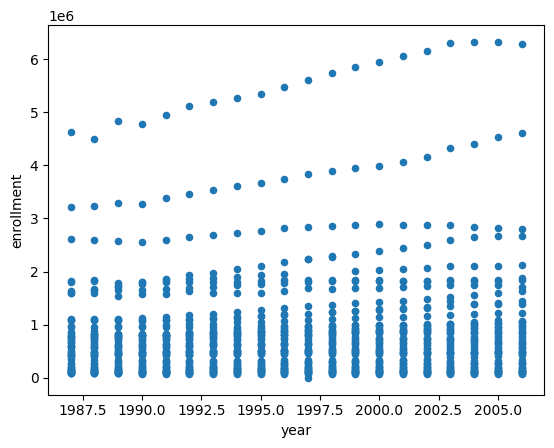

In [ ]:
#plotting
edu_div.plot.scatter(x='year', y='enrollment')

It looks like there are some outliers in the enrollment numbers - a big chunk of the enrollment variable from year to year is less than a million, there are few that tend higher. Predicting enrollment on year alone could lead to some large MSE's.

Additionally, 1997 appears to have an data point enrollment value of 0. This has to be some kind of error, since no state would have 0 students enrolled for an entire year. Let's take a closer look and see which state it is.

In [ ]:
edu[1][edu[1]['enrollment']==0]

,area_name,STCOU,enrollment,year,measurement,division
1806,NEW JERSEY,34000,0,1997,EDU0101,Mid Atlantic


We definitely don't think New Jersey had 0 students enrolled in 1997. Because both the Simple Linear Regression and the Multiple Linear Regression models will utilize this data point to make predictions, we don't want to leave it at 0.

The easiest solution to go with will be to replace the 0 with the average enrollment value for New Jersey for 1996 and 1998 - the two years on either side of missing value.

In [ ]:
edu_div['enrollment'] = edu_div['enrollment'].replace(0, \
(int(edu_div.loc[(edu_div['area_name']=='NEW JERSEY') & (edu_div['year']==1996), 'enrollment']) + \
     int(edu_div.loc[(edu_div['area_name']=='NEW JERSEY') & (edu_div['year']==1998), 'enrollment']))//2)
# return the replaced value to inspect
edu_div.loc[(edu_div['area_name']=='NEW JERSEY') & (edu_div['year']==1997), 'enrollment']

<ipython-input-26-1a0c6b947cdf>:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  (int(edu_div.loc[(edu_div['area_name']=='NEW JERSEY') & (edu_div['year']==1996), 'enrollment']) + \
<ipython-input-26-1a0c6b947cdf>:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(edu_div.loc[(edu_div['area_name']=='NEW JERSEY') & (edu_div['year']==1998), 'enrollment']))//2)


540    1217630
Name: enrollment, dtype: int64

Now that we've gotten an idea of the spread of the ```enrollment``` data and implemented a quick fix for the missing value, we'll continue with the data prep.

For the **Single Linear Regression**, **(SRL)**, we will use ```year``` as the predictor and ```enrollment``` as the target or variable we're trying to make predictions for. In the **Multiple Linear Regression**, **(MLR)**, we'll use ```year``` along with the ```division``` category to try and predict the ```enrollment```.

Here, we'll narrow down our data frame to the three variables of interest

In [ ]:
edu_div = edu_div[['year', 'enrollment', 'division']]

## Dummy Variables

The **MLR** will require us to create dummy variables so the model can account for the ```division``` in which the ```enrollment``` value occurs. Here we'll use the ```pd.get_dummies()``` function on all the divisions except one, since that division will be represented when the others are all zero (0). It does not matter which ```division``` is omitted, so we have randomly selected 'New England' to be the missing ```division```.

Note that we have wrapped the ```pd.get_dummies()``` function in a ```pd.concat()``` function that will add the dummy variables to our dataframe.

In [ ]:
edu_div = pd.concat([edu_div, pd.get_dummies(data=edu_div['division'])\
 [['East North Central', 'Pacific', 'East South Central', 'Mountain', 'West South Central', 'South Atlantic', 'Mid Atlantic', 'West North Central']]], \
                    axis = 1)

Check the first few lines of ```edu_div``` to inspect.

In [ ]:
edu_div.head()

,year,enrollment,division,East North Central,Pacific,East South Central,Mountain,West South Central,South Atlantic,Mid Atlantic,West North Central
0,1987,733735,East South Central,False,False,True,False,False,False,False,False
1,1987,102872,Pacific,False,True,False,False,False,False,False,False
2,1987,609411,Mountain,False,False,False,True,False,False,False,False
3,1987,429260,West South Central,False,False,False,False,True,False,False,False
4,1987,4621126,Pacific,False,True,False,False,False,False,False,False


## Test/Train & Cross Validation

Now we are ready to fit our data to a model. Normally, when fitting data to a model, we would split the data either into **test/train** sets, **cross validation** folds, or both. With **test/train**, we would split the data randomly into a testing set and training set, usually around 80/20. With **cross validation** we select the number of folds to use and the ```cross_validate()``` function from ```sklearn.model_selection``` to iterate through the folds, selecting *n-1* folds to train on and testing on the *'unused'* fold.

However, our current data is time-dependent so we cannot randomly split into **test/train** sets or **cv** folds.

So instead, we will train our model on all the years up to a specified year and then test the model on the next successive year. To do this, we'll need to write our own function to take in a dataframe of predictors, the response variable we are trying to predict, and a year that will delimit the training set from the test set.

## Fit Model & Calculate MSE

In the below ```mse_calc()``` function, we create a ```trainx``` variable based on the ```last_year``` argument. The data will be based solely on the dataframe input of predictors in the 1st argument. The ```trainy``` variable will store the response argrument (enrollment) based on the ```last_year``` argument. Note that the response is taken from our prepared dataframe ```edu_div```.

We repeat the same process to create ```testx``` and ```testy``` variables except that we limit the data to the year after the ```last_year``` argument.

The function will then fit the model on the ```trainx``` and ```trainy``` data. If there is only one variable in the ```df_pred``` argument, then the model will automatically fit to a **SLR**. If there is more than one variable/predictor in the ```df_pred``` argument, then the model will automatically fit to a **MLR**.

Lastly, the function will calculate the **Mean Squared Error** between the actual enrollment values in ```testy``` and the predicted values from ```reg.predict(testx)``` and return this single value.

In [ ]:
def mse_calc(df_pred, response, last_year):
  trainx = df_pred[df_pred['year'] <= last_year]
  trainy = edu_div[edu_div['year'] <= last_year][response]
  testx = df_pred[df_pred['year'] == last_year +1]
  testy = edu_div[edu_div['year'] == last_year +1][response]
  reg = linear_model.LinearRegression()
  reg.fit(trainx, trainy)
  mse1 = mean_squared_error(testy, reg.predict(testx))
  return mse1

### Side Note

```.fit()``` function from ```sklearn.linear_model``` must take in a 2-D shape for the predictor variables. When fitting a **SLR** we had, in the past, reshaped the predictor with ```.values.reshape(-1,1)```. However, if we pass the predictor variable through double brackets ```[[]]```, we end up with the same shape.

In [ ]:
#example
print(edu_div['year'].values.reshape(-1,1).shape)
print(edu_div[['year']].shape)

(1020, 1)
(1020, 1)


This means we can use the same ```mse_calc()``` function for both **SLR** and **MLR** models so long as we pass the first argument through double brackets ```[[]]```

## Test ```mse_calc()```

Let's run the function using a single variable as predictor

In [ ]:
mse_calc(edu_div[['year']], 'enrollment', 2005)

1267149332124.5208

That's a pretty large **MSE**! But if we recall our scatter plot from above, we know our enrollment values from all 50 states has a pretty wide distribution. In the above function, the **SLR** model is predicting one enrollment value for 1990 (```last_year```+ 1) and then comaparing that value to the 50 actual values from `edu_div`. The overall **MSE** is squaring the difference between the prediction and the actual enrollment for each state and summing them together.

Given the wide distribution of enrollments for each state, we would expect such a high **MSE**.

Let's see what kind of result we'll get for one year using multiple predictors.

In [ ]:
mse_calc(edu_div[['year','East North Central', 'Pacific', 'East South Central', 'Mountain', 'West South Central', \
                      'South Atlantic', 'Mid Atlantic', 'West North Central']], 'enrollment', 2005)

976442360373.365

Still pretty large, but significantly less (about 30%) than the single predictor. This makes sense if we think about what the **MLR** is doing. It is predicting nine separate enrollments for the year 1990, each based on the 'division' variable. It then compares the predicted enrollment value of a division to the actual enrollment values for that division and calculates the **MSE** as above. It does this for each of the nine divisions. There is still a lot of variability in enrollments when split into divisions, as reflected in the **MSE**, but less so than when all 50 states are grouped together as in the **SLR**.

## Summing **MSE**'s

Now we want to calculate the sum of all the **MSE**'s from a given year as a starting point up to the end of our dataframe. To do this, we'll write another function that will utilize a ```for loop``` and our helper function.

This function will take in the same first two arguments as the helper function, but the third argument will be the year we use to start calculating **MSE**'s. We need the function to start no earlier than *1989*, so it will have at least two year's worth of data to start training with, so we'll raise an ```Exception``` if the third argument is less than that year.

We will initialize the object ```mse``` at 0 and use it sum all the **MSE**'s with augmented assignment.

Finally, we initialize a ```for loop``` to run the ```mse_calc()``` function for each year between the entered ```first_year``` and the second-to-last year (which results automatically using ```max(edu_div['year'])``` from python's indexing system - i.e. does not include last indexing value). This allows the test set to be run on the last year and the result of each run is assigned to a temporty object (```w```) that is added to the running total in ```mse```.





In [ ]:
def mse_total(df_pred, response, first_year):
  if first_year < 1989:
    raise Exception("first_year arg must be >= 1989")
  mse = 0
  for i in range(first_year, max(edu_div['year'])):
    w = mse_calc(df_pred, response, i)
    mse += w
  return mse

# Final Results

Let's see how it does!

In [ ]:
slr_total_mse = mse_total(edu_div[['year']], 'enrollment', 1990)
mlr_total_mse = mse_total(edu_div[['year','East North Central', 'Pacific', 'East South Central', 'Mountain', 'West South Central', \
                      'South Atlantic', 'Mid Atlantic', 'West North Central']], 'enrollment', 1990)
print(pd.DataFrame({'slr mse': [slr_total_mse], 'mlr mse': [mlr_total_mse]}))

        slr mse       mlr mse
0  1.666754e+13  1.248738e+13


For any given year entered into the function, the **MLR** returns the smaller value. As mentioned above when running the ```mse_calc()``` function, this is because the **MLR** computes a different regression line for each categorical division.  When predicting, it notes for which category the prediction is being made and uses the appropriate regression line. The **SLR** model uses the enrollment data from all 50 states to calculate it's prediction.  While there is still a lot of variability within each division, our calculated **MSE**'s show that there is less variability within the divsions than there is when considering all 50 states together.